# Inicialização

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

In [3]:
ROOT = os.path.abspath('..')
DATA = os.path.join(ROOT, 'data', 'external')
df = pd.read_csv(os.path.join(DATA, 'train.csv'))

In [4]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


# Pré-Processamento

In [6]:
from sklearn.preprocessing import OrdinalEncoder

In [7]:
df.select_dtypes(include=['object'])

,Gender,Vehicle_Age,Vehicle_Damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No
...,...,...,...
381104,Male,1-2 Year,No
381105,Male,< 1 Year,No
381106,Male,< 1 Year,No
381107,Female,> 2 Years,Yes


In [8]:
encoder = OrdinalEncoder()

In [9]:
df[['Gender', 'Vehicle_Age', 'Vehicle_Damage']] = encoder.fit_transform(df.select_dtypes(include=['object']))

In [10]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['1-2 Year', '< 1 Year', '> 2 Years'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

- Gender
    - Male = 1
    - Female = 0
- Vehicle_Age
    - 1-2 Year = 0
    - < 1 Year = 1
    - \> 2 Years = 2
- Vehicle_Damage
    - No = 0
    - Yes = 1

# Treinamento do baseline

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from yellowbrick.classifier import ConfusionMatrix

In [74]:
X = df.drop(labels=['id', 'Response'], axis=1)
y = df['Response']
classes = {0:'nao interessado', 1:'interessado'}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

In [78]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

Analisando os dados de treino

In [79]:
result_train = rfc.predict(X_test)

In [81]:
print(classification_report(y_test, result_train))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93    100195
           1       0.37      0.12      0.18     14138

    accuracy                           0.87    114333
   macro avg       0.63      0.55      0.55    114333
weighted avg       0.82      0.87      0.83    114333



Analisando os dados de teste

In [82]:
df_test = pd.read_csv(os.path.join(DATA, 'test.csv'))

In [83]:
df_test[['Gender', 'Vehicle_Age', 'Vehicle_Damage']] = encoder.transform(df_test.select_dtypes(include=['object']))

In [84]:
X_test_fine = df_test.drop(labels=['id'], axis=1)

In [87]:
result_test_fine = rfc.predict(X_test_fine)

In [86]:
df_target = pd.read_csv(os.path.join(DATA, 'sample_submission.csv'))
y_test_fine = df_target['Response']

In [88]:
print(classification_report(y_test_fine, result_test_fine, zero_division=True ))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    127037
           1       0.00      1.00      0.00         0

    accuracy                           0.96    127037
   macro avg       0.50      0.98      0.49    127037
weighted avg       1.00      0.96      0.98    127037



Interpretar métricas <br>
https://medium.com/kunumi/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-em-machine-learning-classifica%C3%A7%C3%A3o-49340dcdb198

In [89]:
cm = confusion_matrix(y_test_fine, result_test_fine)

In [90]:
TP = cm[1][1]
FP = cm[1][0]
TN = cm[0][0]
FN = cm[0][1]

acc = (TP + TN) / (TP + TN + FP + FN)
acc

0.9598620874233491

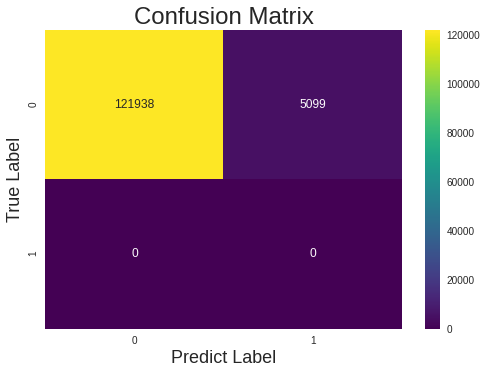

In [91]:
sns.heatmap(data=confusion_matrix(y_test_fine, result_test_fine), annot=True, fmt='g', cmap='viridis')
plt.title('Confusion Matrix', fontsize= 24)
plt.xlabel('Predict Label', fontsize= 18)
plt.ylabel('True Label', fontsize= 18);

In [92]:
# np.unique(result_test, return_counts=True)
print (pd.crosstab(y_test_fine, result_test_fine, rownames=['Real'], colnames=['      Predito'], margins=True))

      Predito       0     1     All
Real                               
0              121938  5099  127037
All            121938  5099  127037


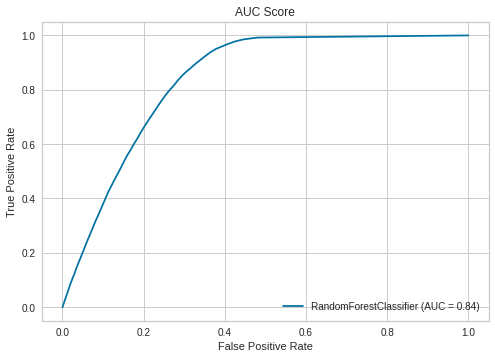

In [148]:
plot_roc_curve(rfc, X_test, y_test)
plt.title('AUC Score');

In [149]:
from yellowbrick.classifier import ROCAUC

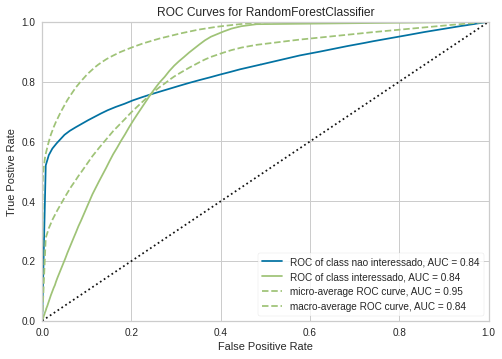

In [151]:
visualizer = ROCAUC(rfc, classes=["nao interessado", "interessado"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();

plot graph https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html

Interpretar ROC e AUC <br>
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5 <br>
https://towardsdatascience.com/understanding-the-roc-curve-and-auc-dd4f9a192ecb

## Verificando as features mais importantes

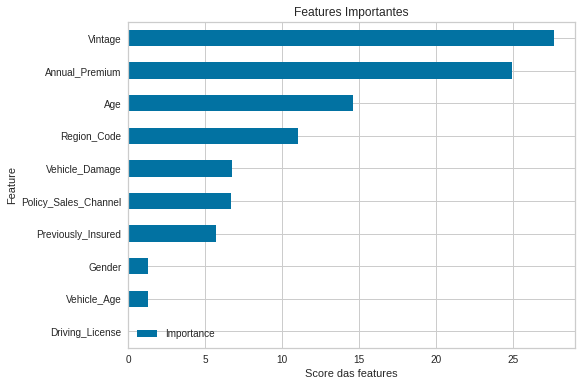

In [146]:
featureImp = []
for feat, importance in zip(X_train.columns, rfc.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

feature_importances = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
feature_importances.set_index(['Feature'], inplace= True)
feature_importances.sort_values('Importance', ascending = True).plot(kind='barh', figsize=(8,6))
plt.title('Features Importantes')
plt.xlabel('Score das features');

# Estruturando pipeline